INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.37s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


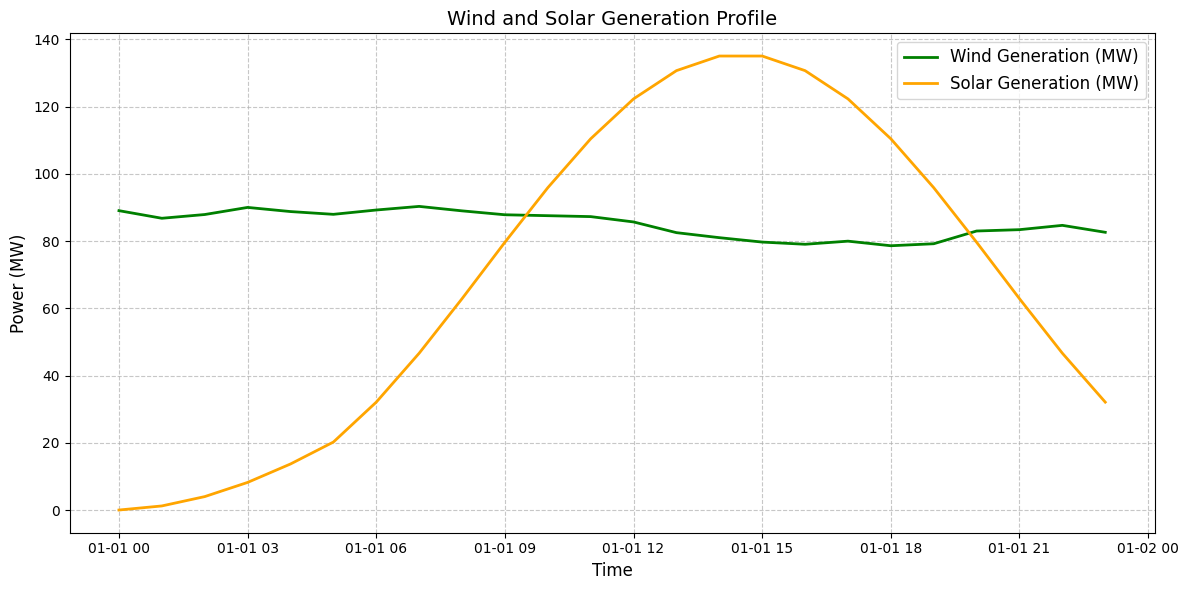

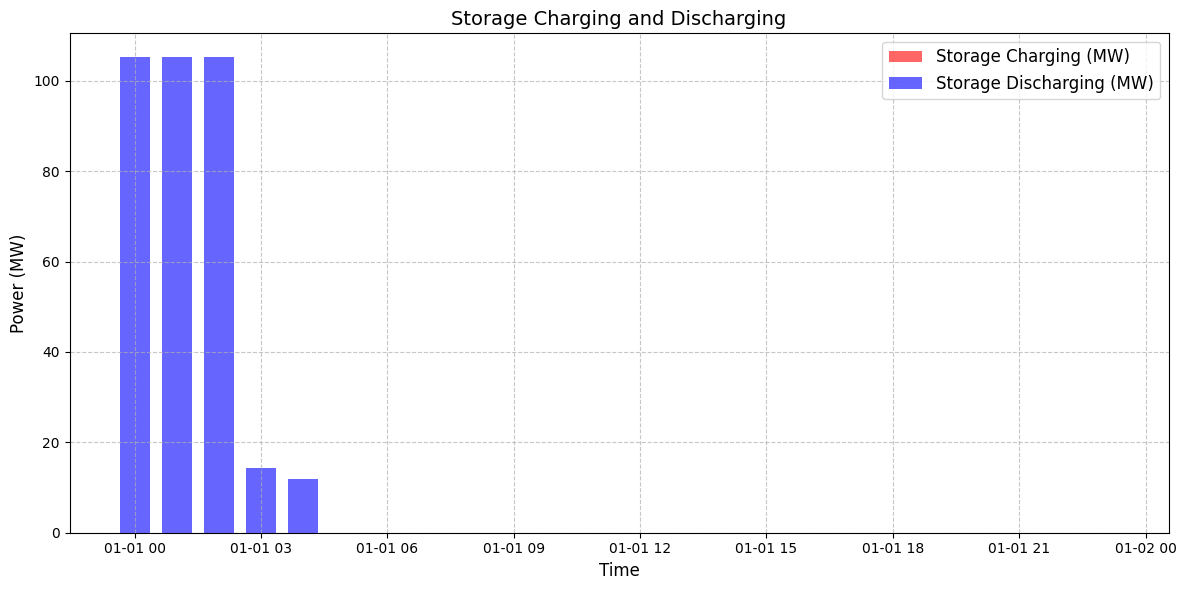

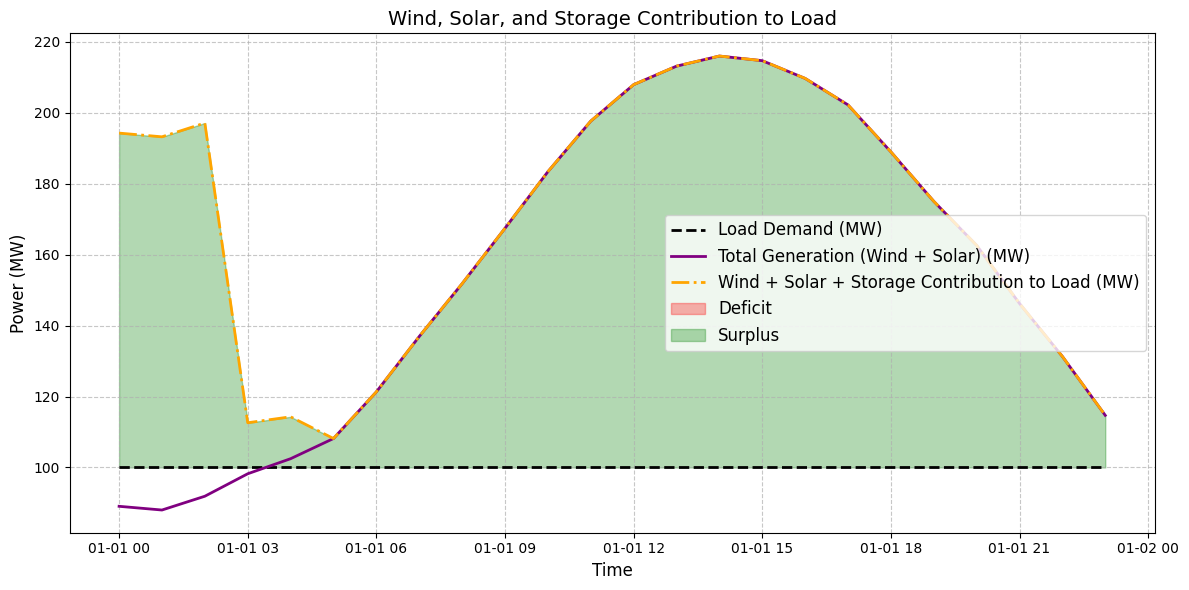

In [2]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the network
network = pypsa.Network()

# Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (solar and wind generators to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)

# Generate a smoother wind profile using larger variability
np.random.seed(42)  # For reproducibility
base_wind_speed = 0.6  # Average capacity factor (60%)
variability = 0.05  # Reduced variability for even smoother profile
wind_profile = pd.Series(
    base_wind_speed + variability * np.random.randn(len(hours)),
    index=hours
).clip(lower=0, upper=1)  # Ensure the values are between 0 and 1

# Apply a stronger moving average (window size = 6) for smoother profile
wind_profile_smooth = wind_profile.rolling(window=6, min_periods=1).mean()

# Generate solar profile
solar_profile = pd.Series(0.5 * (1 + np.sin(2 * np.pi * (hours.hour - 6) / 24)), index=hours)  # Solar profile peaks at midday

# Apply a moving average to smooth the solar generation slightly (optional)
solar_profile_smooth = solar_profile.rolling(window=6, min_periods=1).mean()

# Add Wind Generator
p_nom_wind = 150  # Nominal power (MW)
network.add("Generator", "Wind Generator", bus="bus1", p_nom=p_nom_wind, p_max_pu=wind_profile_smooth, carrier="wind")

# Add Solar Generator
p_nom_solar = 150  # Nominal power (MW)
network.add("Generator", "Solar Generator", bus="bus1", p_nom=p_nom_solar, p_max_pu=solar_profile_smooth, carrier="solar")

# Add Inverter (as a link)
inverter_efficiency = 0.95
network.add("Link", "Inverter", bus0="bus1", bus1="bus2", p_nom=p_nom_solar * 2, efficiency=inverter_efficiency, carrier="inverter")

# Define constant load demand
p_load = 100  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)  # Constant across all snapshots

# Add Load
network.add("Load", "Load", bus="bus2", p_set=load_demand)

# Add Storage Unit
network.add(
    "StorageUnit",
    "Battery Storage",
    bus="bus1",
    p_nom=200,  # Maximum charging/discharging power (MW)
    max_hours=4,  # Max energy storage in hours
    efficiency_store=0.9,  # Charging efficiency
    efficiency_dispatch=0.9,  # Discharging efficiency
    state_of_charge_initial=400,  # Initial state of charge (MWh)
    carrier="battery",
)

# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

# Extract results
wind_generation = wind_profile_smooth * p_nom_wind * inverter_efficiency  # Wind generation after inverter
solar_generation = solar_profile_smooth * p_nom_solar * inverter_efficiency  # Solar generation after inverter
storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
storage_charging = storage_dispatch.clip(upper=0)  # Charging (negative values)
storage_discharging = storage_dispatch.clip(lower=0)  # Discharging (positive values)
total_generation = wind_generation + solar_generation  # Total generation from wind + solar
total_to_load = total_generation + storage_dispatch  # Combined wind, solar, and storage contribution to load

# Plot 1: Wind and Solar Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.plot(hours, solar_generation, label="Solar Generation (MW)", color="orange", linewidth=2)
plt.title("Wind and Solar Generation Profile", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Storage Activity
plt.figure(figsize=(12, 6))
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="blue", alpha=0.6, width=0.03)
plt.title("Storage Charging and Discharging", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Total Contribution to Load (Wind + Solar + Storage)
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, total_generation, label="Total Generation (Wind + Solar) (MW)", color="purple", linewidth=2)
plt.plot(hours, total_to_load, label="Wind + Solar + Storage Contribution to Load (MW)", color="orange", linestyle="-.", linewidth=2)
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load < load_demand), interpolate=True, color="red", alpha=0.3, label="Deficit")
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load >= load_demand), interpolate=True, color="green", alpha=0.3, label="Surplus")
plt.title("Wind, Solar, and Storage Contribution to Load", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.57s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


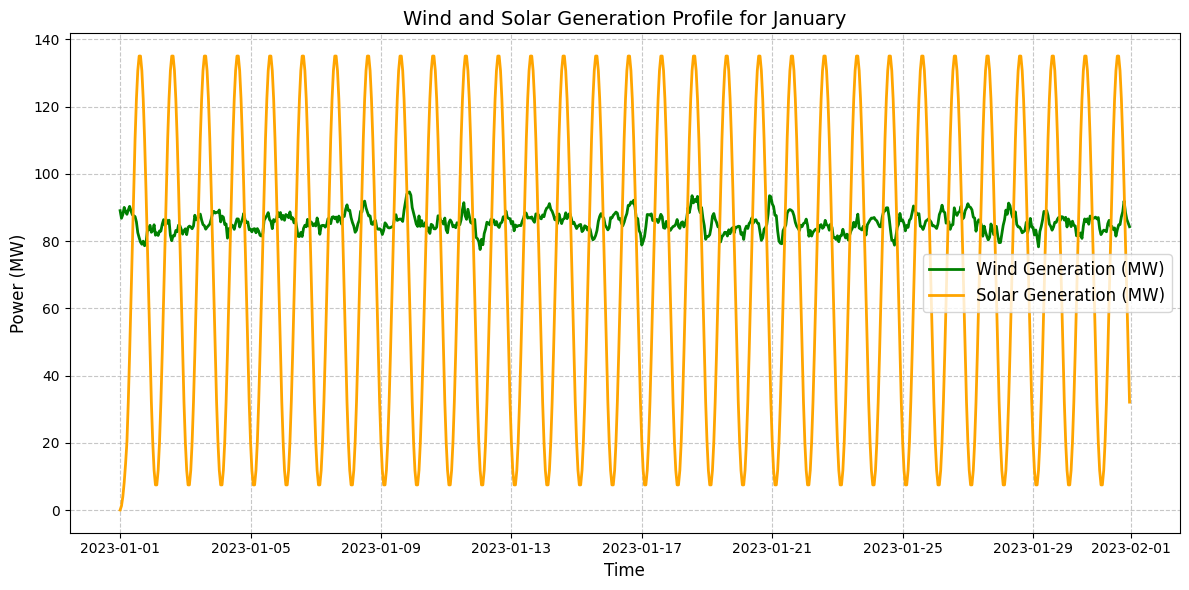

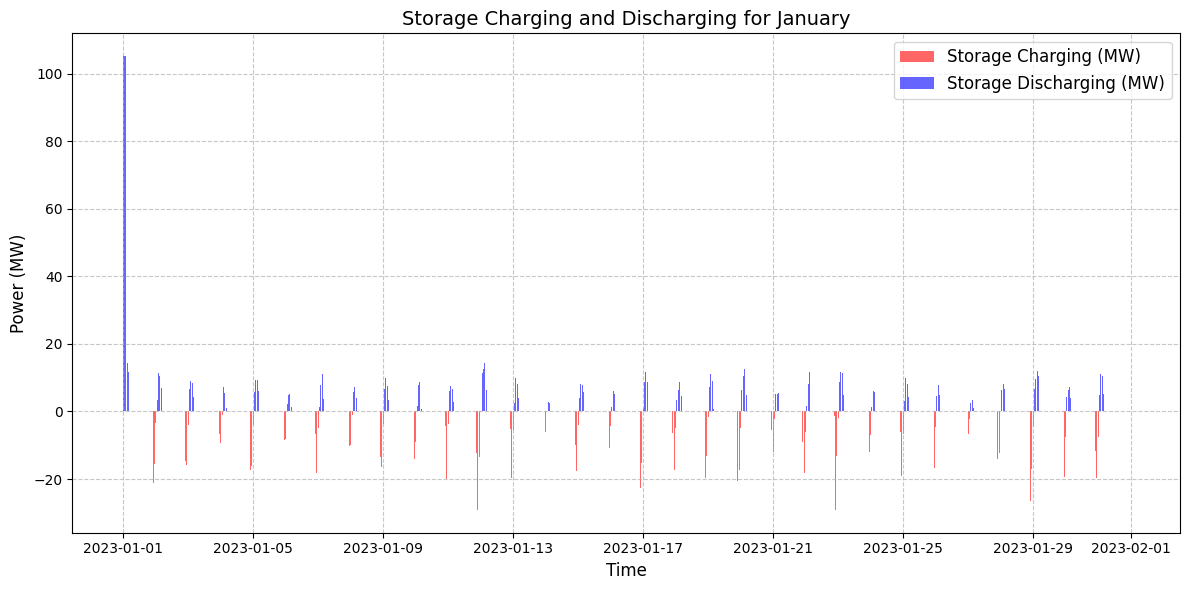

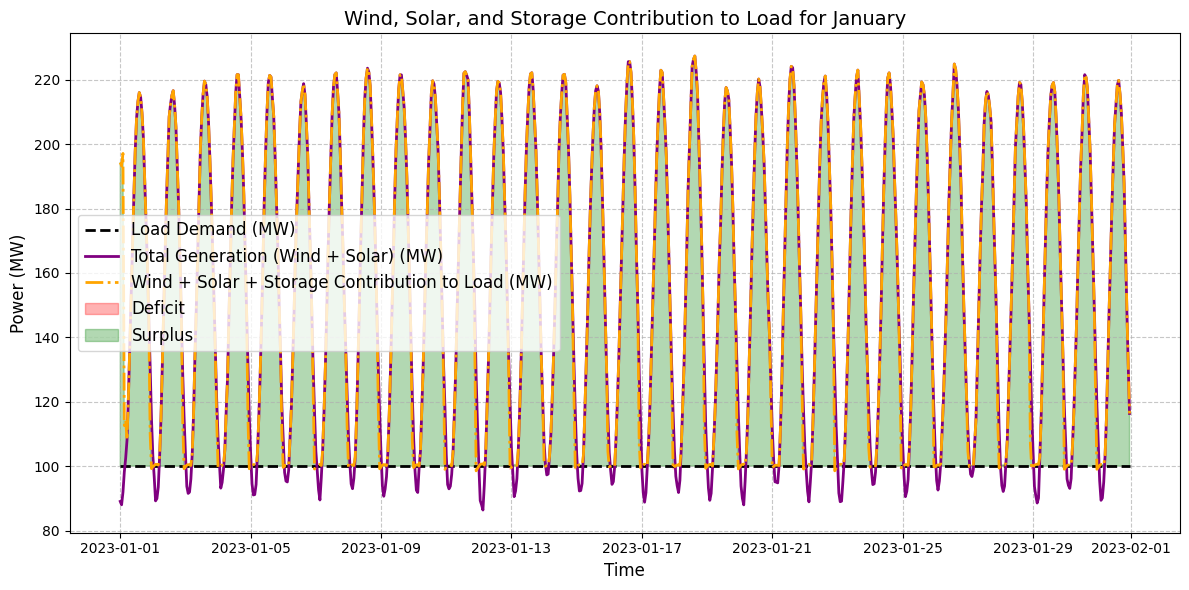

In [5]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the network
network = pypsa.Network()

# Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (solar and wind generators to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# Define time steps for the simulation (one month: January 1st to January 31st)
hours = pd.date_range("2023-01-01 00:00", "2023-01-31 23:00", freq="H")
network.set_snapshots(hours)

# Generate a smoother wind profile using larger variability
np.random.seed(42)  # For reproducibility
base_wind_speed = 0.6  # Average capacity factor (60%)
variability = 0.05  # Reduced variability for even smoother profile
wind_profile = pd.Series(
    base_wind_speed + variability * np.random.randn(len(hours)),
    index=hours
).clip(lower=0, upper=1)  # Ensure the values are between 0 and 1

# Apply a stronger moving average (window size = 6) for smoother profile
wind_profile_smooth = wind_profile.rolling(window=6, min_periods=1).mean()

# Generate solar profile
solar_profile = pd.Series(0.5 * (1 + np.sin(2 * np.pi * (hours.hour - 6) / 24)), index=hours)  # Solar profile peaks at midday

# Apply a moving average to smooth the solar generation slightly (optional)
solar_profile_smooth = solar_profile.rolling(window=6, min_periods=1).mean()

# Add Wind Generator
p_nom_wind = 150  # Nominal power (MW)
network.add("Generator", "Wind Generator", bus="bus1", p_nom=p_nom_wind, p_max_pu=wind_profile_smooth, carrier="wind")

# Add Solar Generator
p_nom_solar = 150  # Nominal power (MW)
network.add("Generator", "Solar Generator", bus="bus1", p_nom=p_nom_solar, p_max_pu=solar_profile_smooth, carrier="solar")

# Add Inverter (as a link)
inverter_efficiency = 0.95
network.add("Link", "Inverter", bus0="bus1", bus1="bus2", p_nom=p_nom_solar * 2, efficiency=inverter_efficiency, carrier="inverter")

# Define constant load demand
p_load = 100  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)  # Constant across all snapshots

# Add Load
network.add("Load", "Load", bus="bus2", p_set=load_demand)

# Add Storage Unit
network.add(
    "StorageUnit",
    "Battery Storage",
    bus="bus1",
    p_nom=200,  # Maximum charging/discharging power (MW)
    max_hours=4,  # Max energy storage in hours
    efficiency_store=0.9,  # Charging efficiency
    efficiency_dispatch=0.9,  # Discharging efficiency
    state_of_charge_initial=400,  # Initial state of charge (MWh)
    carrier="battery",
)

# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

# Extract results
wind_generation = wind_profile_smooth * p_nom_wind * inverter_efficiency  # Wind generation after inverter
solar_generation = solar_profile_smooth * p_nom_solar * inverter_efficiency  # Solar generation after inverter
storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
storage_charging = storage_dispatch.clip(upper=0)  # Charging (negative values)
storage_discharging = storage_dispatch.clip(lower=0)  # Discharging (positive values)
total_generation = wind_generation + solar_generation  # Total generation from wind + solar
total_to_load = total_generation + storage_dispatch  # Combined wind, solar, and storage contribution to load

# Plot 1: Wind and Solar Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.plot(hours, solar_generation, label="Solar Generation (MW)", color="orange", linewidth=2)
plt.title("Wind and Solar Generation Profile for January", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Storage Activity
plt.figure(figsize=(12, 6))
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="blue", alpha=0.6, width=0.03)
plt.title("Storage Charging and Discharging for January", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Total Contribution to Load (Wind + Solar + Storage)
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, total_generation, label="Total Generation (Wind + Solar) (MW)", color="purple", linewidth=2)
plt.plot(hours, total_to_load, label="Wind + Solar + Storage Contribution to Load (MW)", color="orange", linestyle="-.", linewidth=2)
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load < load_demand), interpolate=True, color="red", alpha=0.3, label="Deficit")
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load >= load_demand), interpolate=True, color="green", alpha=0.3, label="Surplus")
plt.title("Wind, Solar, and Storage Contribution to Load for January", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
